In [1]:
include("../speciale_tools.jl")
import JLD
import PyPlot

In [2]:
figure_folder = "/home/data/simon/result/figures_repport/scalgo"

"/home/data/simon/result/figures_repport/scalgo"

## Vejle



In [3]:
data_folder = "/home/data/simon/processed/test_areas/vejle_new"
#data_folder = "/Users/simon/Documents/DTU fag/Speciale/ribe_new"
VV_files,VH_files,coherence_VV_files,coherence_VH_files = _sort_prossed_files(data_folder);
coh = [abs.(band) for band in _load_jld(coherence_VV_files[1:5],data_folder)]
coh = [coh[1][:,end:-1:1],(sum(coh[2:end])./length(coh[2:end]))[:,end:-1:1]];

VV = _load_jld(VV_files[1:6],data_folder)
VV_pre = dropdims(Statistics.median(cat(VV[2:end]...,dims=3),dims=3),dims=3)[:,end:-1:1];
VV_co = copy(VV[1])[:,end:-1:1]
VV = 0;


VH = _load_jld(VH_files[1:6],data_folder)
VH_pre = dropdims(Statistics.median(cat(VH[2:end]...,dims=3),dims=3),dims=3)[:,end:-1:1];
VH_co = copy(VH[1])[:,end:-1:1]
VH = 0;

In [4]:
geo_lut = JLD.load(joinpath(data_folder ,"coordinates.jld"));

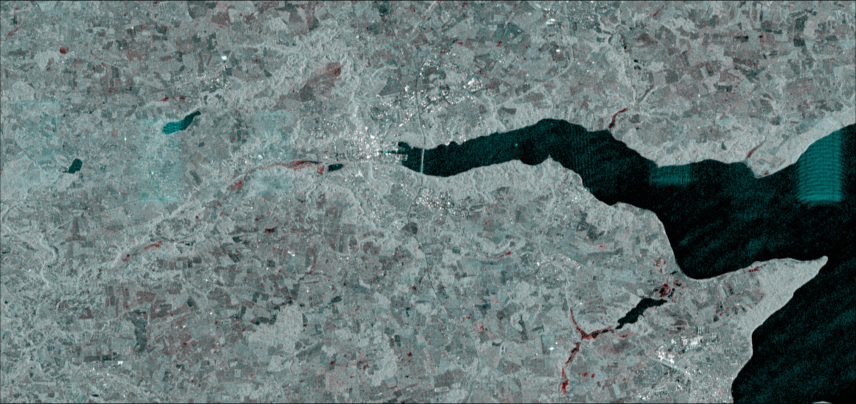

In [5]:
imgVV = pretty_img([VV_co,VV_pre],min_vv,max_vv)
imgVH = pretty_img([VH_co,VH_pre],min_vh,max_vh)

In [125]:
img_bw = pretty_img([VV_pre,VV_pre],min_vv,max_vv,1);
img_bw_vh = pretty_img([VH_co,VH_co],min_vh,max_vh,1);

In [7]:

own_bare = JLD.load(joinpath(data_folder,"own_bare_soil.jld"),"data");
hasard = JLD.load(joinpath(data_folder,"hasard.jld"),"data")[:,end:-1:1].>0.5;

### RESAMPLE

In [10]:
ndimage = PyCall.pyimport("scipy.ndimage");
rasterio = PyCall.pyimport("rasterio");
function _load_scalgo(depth_path, lake_path, geo_lut; scalgo_fill = -10, resample_fill=-100)
    
    ### Water depths
    depth_tiff = rasterio.open(depth_path);
    transform1 = depth_tiff.get_transform()
    scalgo_depth = depth_tiff.read(1)[1:10:end,1:10:end];
    # Set new negative values    
    scalgo_depth[scalgo_depth .<0] .= scalgo_fill
    ## Resample 
    idx1 = reshape((geo_lut["latitude"].-transform1[4])./(transform1[6]*10),:);
    idx2 = reshape((geo_lut["longitude"].-transform1[1])./(transform1[2]*10),:);
    index = [idx1,idx2];
    flood_val  = ndimage.map_coordinates(scalgo_depth, index, order=1, mode="constant",cval=resample_fill);
    flood_val = reshape(flood_val,size(geo_lut["latitude"]));
    
    
    ### Lakes
    lakes_tiff = rasterio.open(lake_path);
    transform2 = lakes_tiff.get_transform()
    scalgo_lakes = lakes_tiff.read(1)[1:10:end,1:10:end];
    # Set new negative values    
    scalgo_lakes[scalgo_lakes .<0] .= scalgo_fill
    # Resample 
    idx1 = reshape((geo_lut["latitude"].-transform2[4])./(transform1[6]*10),:);
    idx2 = reshape((geo_lut["longitude"].-transform2[1])./(transform1[2]*10),:);
    index = [idx1,idx2];
    lakes = ndimage.map_coordinates(scalgo_lakes, index, order=1, mode="constant",cval=resample_fill);
    lakes  = reshape(lakes ,size(geo_lut["latitude"]));
    
    
    return flood_val, lakes
end

_load_scalgo (generic function with 1 method)

### testcase 1

In [126]:
scalgo_folder = "/home/data/simon/result/scalgo/vejle_1"

"/home/data/simon/result/scalgo/vejle_1"

In [127]:
flood_val, lakes =  _load_scalgo(
                                joinpath(scalgo_folder,"vanddybde_vejle1.tif"), 
                                joinpath(scalgo_folder,"geo_dk_lakes_vejle1.tif"),
                                geo_lut);

In [128]:
scalgo_mask = flood_val[:,end:-1:1] .> -50;
flood_mask = (flood_val[:,end:-1:1] .> 0.05) .& .!(lakes[:,end:-1:1] .> 0.01);

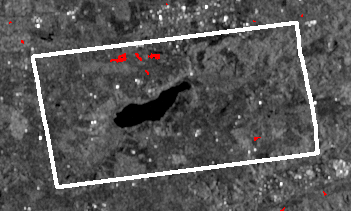

In [129]:
img_save = add_mask(img_bw,get_edges(scalgo_mask,1),(1,1,1))
img_save = add_mask(img_save,own_bare,(1,0,0))
img_save = img_save[140:350,211:561]
file_path = joinpath(figure_folder,"case_1_rebel")
FileIO.save(file_path*".png",img_save)
img_save

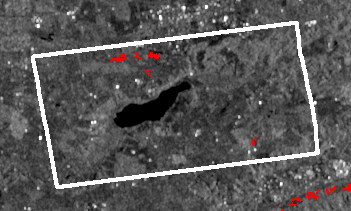

In [130]:
img_save = add_mask(img_bw,get_edges(scalgo_mask,1),(1,1,1))
img_save = add_mask(img_save,hasard,(1,0,0))
img_save = img_save[140:350,211:561]
file_path = joinpath(figure_folder,"case_1_hasard")
FileIO.save(file_path*".png",img_save)
img_save

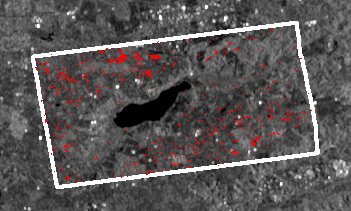

In [131]:
img_save = add_mask(img_bw,get_edges(scalgo_mask,1),(1,1,1))
img_save = add_mask(img_save,flood_mask,(1,0,0))
img_save = img_save[140:350,211:561]
file_path = joinpath(figure_folder,"case_1_scalgo")
FileIO.save(file_path*".png",img_save)
img_save

In [132]:
flood_maps = [own_bare[scalgo_mask],hasard[scalgo_mask],flood_mask[scalgo_mask]];

In [133]:
i =1
[(sum(elem .& flood_maps[i])/sum(elem),sum(elem .& flood_maps[i]))  for elem in flood_maps]

3-element Array{Tuple{Float64,Int64},1}:
 (1.0, 180)                
 (0.7282608695652174, 134) 
 (0.10785953177257525, 129)

In [134]:
i =2
[(sum(elem .& flood_maps[i])/sum(elem),sum(elem .& flood_maps[i]))  for elem in flood_maps]

3-element Array{Tuple{Float64,Int64},1}:
 (0.7444444444444445, 134) 
 (1.0, 184)                
 (0.10451505016722408, 125)

In [135]:
i =3
[(sum(elem .& flood_maps[i])/sum(elem),sum(elem .& flood_maps[i]))  for elem in flood_maps]

3-element Array{Tuple{Float64,Int64},1}:
 (0.7166666666666667, 129)
 (0.6793478260869565, 125)
 (1.0, 1196)              

### Test area 2 

In [136]:
scalgo_folder = "/home/data/simon/result/scalgo/vejle2"

"/home/data/simon/result/scalgo/vejle2"

In [137]:
flood_val, lakes =  _load_scalgo(
                                joinpath(scalgo_folder,"flood.tif"), 
                                joinpath(scalgo_folder,"lakes_vejle2.tif"),
                                geo_lut);

In [138]:
scalgo_mask = flood_val[:,end:-1:1] .> -50;
flood_mask = (flood_val[:,end:-1:1] .> 0.05) .& .!(lakes[:,end:-1:1] .> 0.01);

In [139]:
1711-800,1711-1200

(911, 511)

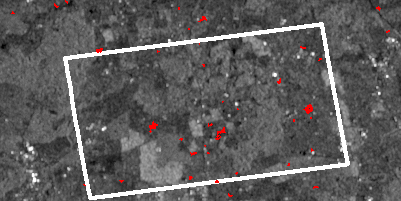

In [140]:
img_save = add_mask(img_bw,get_edges(scalgo_mask,1),(1,1,1))
img_save = add_mask(img_save,own_bare,(1,0,0))
img_save = img_save[600:800,511:911]
file_path = joinpath(figure_folder,"case_2_rebel")
FileIO.save(file_path*".png",img_save)
img_save

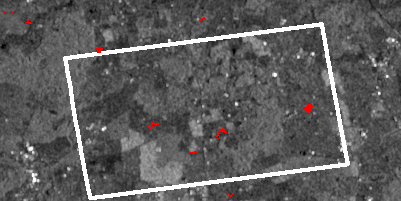

In [141]:
img_save = add_mask(img_bw,get_edges(scalgo_mask,1),(1,1,1))
img_save = add_mask(img_save,hasard,(1,0,0))
img_save = img_save[600:800,511:911]
file_path = joinpath(figure_folder,"case_2_hasard")
FileIO.save(file_path*".png",img_save)
img_save

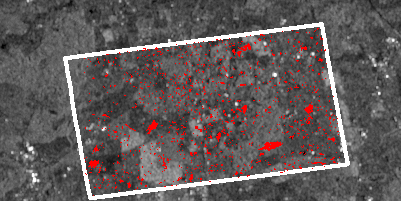

In [142]:
img_save = add_mask(img_bw,get_edges(scalgo_mask,1),(1,1,1))
img_save = add_mask(img_save,flood_mask,(1,0,0))
img_save = img_save[600:800,511:911]
file_path = joinpath(figure_folder,"case_2_scalgo")
FileIO.save(file_path*".png",img_save)
img_save

In [143]:
flood_maps = [own_bare[scalgo_mask],hasard[scalgo_mask],flood_mask[scalgo_mask]];

In [144]:
i =1
[(sum(elem .& flood_maps[i])/sum(elem),sum(elem .& flood_maps[i]))  for elem in flood_maps]

3-element Array{Tuple{Float64,Int64},1}:
 (1.0, 310)                
 (0.8028169014084507, 114) 
 (0.08974358974358974, 210)

In [145]:
i =2
[(sum(elem .& flood_maps[i])/sum(elem),sum(elem .& flood_maps[i]))  for elem in flood_maps]

3-element Array{Tuple{Float64,Int64},1}:
 (0.36774193548387096, 114)
 (1.0, 142)                
 (0.04358974358974359, 102)

In [146]:
i =3
[(sum(elem .& flood_maps[i])/sum(elem),sum(elem .& flood_maps[i]))  for elem in flood_maps]

3-element Array{Tuple{Float64,Int64},1}:
 (0.6774193548387096, 210)
 (0.7183098591549296, 102)
 (1.0, 2340)              

## Testcase 3

In [147]:
scalgo_folder = "/home/data/simon/result/scalgo/vejle3"

"/home/data/simon/result/scalgo/vejle3"

In [148]:
flood_val, lakes =  _load_scalgo(
                                joinpath(scalgo_folder,"flood.tif"), 
                                joinpath(scalgo_folder,"lakes_vejle3.tif"),
                                geo_lut);

In [149]:
scalgo_mask = flood_val[:,end:-1:1] .> -50;
flood_mask = (flood_val[:,end:-1:1] .> 0.05) .& .!(lakes[:,end:-1:1] .> 0.01);

In [150]:
1711-300,1711- 650

(1411, 1061)

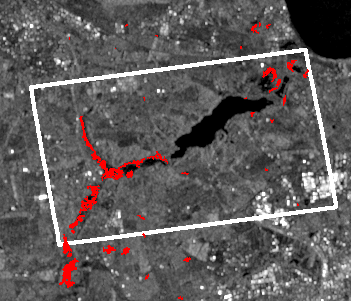

In [151]:
img_save = add_mask(img_bw,get_edges(scalgo_mask,1),(1,1,1))
img_save = add_mask(img_save,own_bare,(1,0,0))
img_save = img_save[500:800,1061:1411]
file_path = joinpath(figure_folder,"case_3_rebel")
FileIO.save(file_path*".png",img_save)
img_save

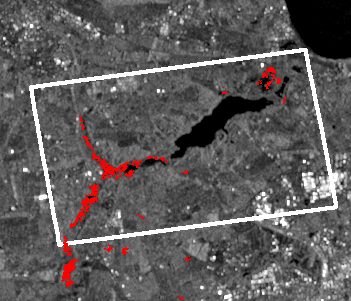

In [152]:
img_save = add_mask(img_bw,get_edges(scalgo_mask,1),(1,1,1))
img_save = add_mask(img_save,hasard,(1,0,0))
img_save = img_save[500:800,1061:1411]
file_path = joinpath(figure_folder,"case_3_hasard")
FileIO.save(file_path*".png",img_save)
img_save

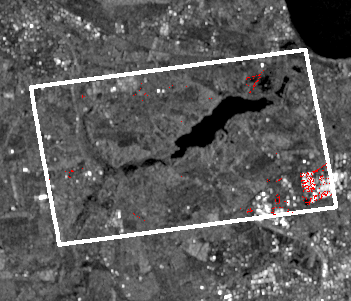

In [153]:
img_save = add_mask(img_bw,get_edges(scalgo_mask,1),(1,1,1))
img_save = add_mask(img_save,flood_mask,(1,0,0))
img_save = img_save[500:800,1061:1411]
file_path = joinpath(figure_folder,"case_3_scalgo")
FileIO.save(file_path*".png",img_save)
img_save

In [154]:
flood_maps = [own_bare[scalgo_mask],hasard[scalgo_mask],flood_mask[scalgo_mask]];

In [155]:
i =1
[(sum(elem .& flood_maps[i])/sum(elem),sum(elem .& flood_maps[i]))  for elem in flood_maps]

3-element Array{Tuple{Float64,Int64},1}:
 (1.0, 1236)              
 (0.7263374485596708, 706)
 (0.0, 0)                 

In [156]:
i =2
[(sum(elem .& flood_maps[i])/sum(elem),sum(elem .& flood_maps[i]))  for elem in flood_maps]

3-element Array{Tuple{Float64,Int64},1}:
 (0.5711974110032363, 706)
 (1.0, 972)               
 (0.0, 0)                 

In [157]:
i =3
[(sum(elem .& flood_maps[i])/sum(elem),sum(elem .& flood_maps[i]))  for elem in flood_maps]

3-element Array{Tuple{Float64,Int64},1}:
 (0.0, 0)  
 (0.0, 0)  
 (1.0, 329)

In [158]:
zip_folder(figure_folder)

Process(`zip -q -j -r /home/data/simon/result/figures_repport/scalgo.zip /home/data/simon/result/figures_repport/scalgo`, ProcessExited(0))

In [ ]:
#### scalgo 